In [2]:
!pip install pyforest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14607 sha256=2f624c60bb47604dbe092063d9c2ff39d411a07ccae318e788680b7bab58ce5b
  Stored in directory: /root/.cache/pip/wheels/61/1c/da/48e6c884142d485475d852d69d20a096aba5beceb338822893
Successfully built pyforest


In [3]:
#import splitfolders
import pyforest
import torch
from torchvision.models import mobilenet_v3_large , MobileNet_V3_Large_Weights
from torch import nn, optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
mnet_weight = MobileNet_V3_Large_Weights.IMAGENET1K_V2

bs = 100
crop_size = 254

test_transform = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
])

test_set = datasets.ImageFolder("/content/drive/MyDrive/belajar python/case study/forest fire/img/val", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [15]:
label2cat = test_set.classes
print(label2cat)

['fire', 'no_fire']


In [17]:
class ForestFireRecognition(nn.Module):
    def __init__(self):
        super().__init__()
        self.mnet = model = mobilenet_v3_large(mnet_weight)
        self.mnet.classifier = nn.Sequential(
            nn.Hardswish(),
            nn.Linear(960,1280),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(1280,2),
            nn.LogSoftmax(1)
        )
    def forward(self,x) :
        x = self.mnet(x)
        return x

In [ ]:
model = ForestFireRecognition().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/belajar python/case study/forest fire/model/mobilenetv3_98.pth",map_location=torch.device('cpu')))
model.to(device)

In [19]:
itr = iter(testloader)
feature,target = next(itr)
feature , target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval()
    output = model(feature)
    pred = output.argmax(1)
    y_pred = pred.cpu().tolist()

In [20]:
y_true = test_set.targets

In [21]:
from sklearn.metrics import accuracy_score,classification_report
accuracy_score(y_true,y_pred)

0.9880952380952381

In [22]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        42
           1       0.98      1.00      0.99        42

    accuracy                           0.99        84
   macro avg       0.99      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84



In [23]:

def clfr_plot(y_true,y_pred):

    clf_report_test = classification_report(
        y_true, y_pred, output_dict=True)

    sns.heatmap(pd.DataFrame(
        clf_report_test).iloc[:-1, :].T, annot=True, cmap="YlGnBu", vmin=0, vmax=1, linewidths=0.5)
    plt.show()

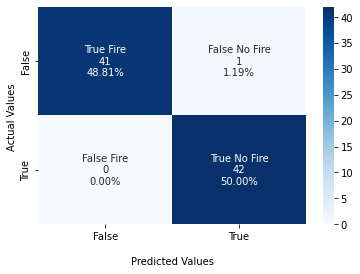

In [24]:
cf_matrix = confusion_matrix(y_true, y_pred)

group_names = ['True Fire','False No Fire','False Fire','True No Fire']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Classification Report

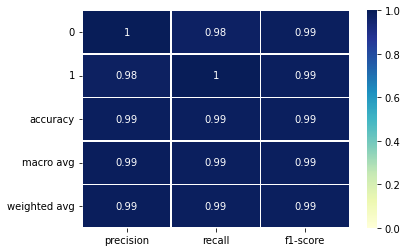

In [25]:
clfr_plot(y_true,y_pred)

## True Positive and False positive rate

## Image Preview

In [27]:
fig,axes = plt.subplots(8,8,figsize = (30,30))
for image , label, pred, ax in zip(feature,target,pred,axes.flatten()):
  ax.imshow(image.permute(1,2,0).cpu())
  font = {"color" : "r"} if label != pred else {"color" : "g"}
  label,pred = label2cat[label.item()] , label2cat[pred.item()]
  ax.set_title(f"L : {label}    | P : {pred}  ",  fontdict = font )
  ax.axis("off");

Output hidden; open in https://colab.research.google.com to view.

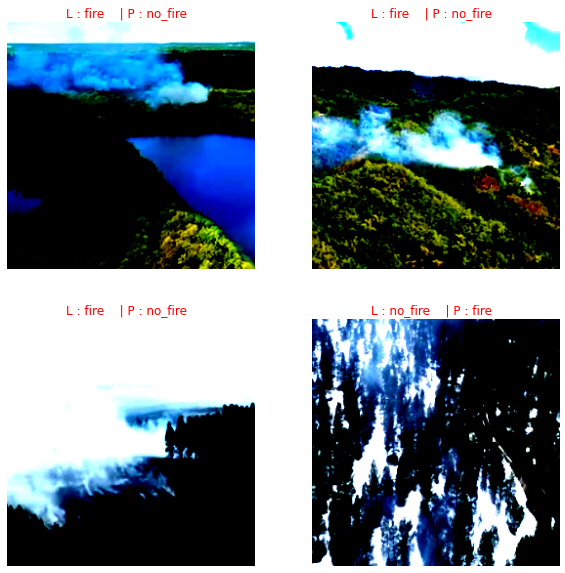

In [ ]:
fig,axes = plt.subplots(2,2,figsize = (10,10))
for image , label, pred, ax in zip(feature[false_pred],target[false_pred],preds[false_pred],axes.flatten()):
  ax.imshow(image.permute(1,2,0).cpu())
  font = {"color" : "r"} if label != pred else {"color" : "g"}
  label,pred = label2cat[label.item()] , label2cat[pred.item()]
  ax.set_title(f"L : {label}    | P : {pred}  ",  fontdict = font )
  ax.axis("off");

Saving images.jpg to images.jpg
images.jpg


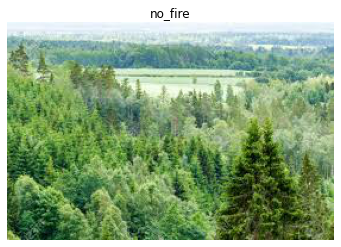

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files

uploaded = files.upload()
 
for fn in uploaded.keys():
 
    path = fn
    img = Image.open(path)
    
    imgplot = plt.imshow(img)
    img_trans = test_transform(img)
    img_trans = img_trans.to(device)
    img_trans = img_trans[None,:]
 
    with torch.no_grad():
        model.eval()
        out = model(img_trans) 
        pred = label2cat[out.argmax(1)[0]]
    print(fn)
    plt.title(pred)
    plt.axis("off")